In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tensorboardX import SummaryWriter

import time
from datetime import datetime
import json
import traceback
import logging
import importlib
import shutil
from collections import defaultdict
%matplotlib inline

from yolo_model import yoloModel
from PASCAL_Dataloader import create_split_loaders
from YOLO_Loss import YoloLoss

total_loss = defaultdict(dict)
avg_minibatch_loss = []
avg_valid_loss = []
avg_test_loss = defaultdict(dict)
_validation_metrics = defaultdict(dict)
tot_test_outputs = []
tot_test_labels = []

log = {}

In [2]:
def train(config):
    config['global_step'] = config.get('start_step', 0)
    is_training = False if config.get('export_onnx') else True

    # TODO: Load and initialize network
    net = yoloModel(config)

    # Define the optimizer and learning rate
    optimizer = obtain_optimizer(config, net)
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer,
        step_size=config['decay_step'],
        gamma=config['decay_gamma'])

    # Use pretrained model
    if config['pretrain_snapshot']:
        logging.info('Load pretrained weights from {}'.format(config['pretrain_snapshot']))
        state_dict = torch.load(config['pretrain_snapshot'])
        net.load_state_dict(state_dict)

    # Use all 3 scales for computing YOLO loss
    YOLO_losses = []
    val_YOLO_losses = []
    test_YOLO_losses = []
    for i in range(3):
        YOLO_losses.append(YoloLoss(config['classes'], (config['img_w'], config['img_h']), config['anchors'][i]))
        val_YOLO_losses.append(YoloLoss(config['classes'], (config['img_w'], config['img_h']), config['anchors'][i]))
        test_YOLO_losses.append(YoloLoss(config['classes'], (config['img_w'], config['img_h']), config['anchors'][i]))

    # Check if your system supports CUDA
    use_cuda = torch.cuda.is_available()

    # Setup GPU optimization if CUDA is supported
    if use_cuda:
        computing_device = torch.device("cuda")
        extras = {"num_workers": 3, "pin_memory": True}
        print("CUDA is supported")
    else: # Otherwise, train on the CPU
        computing_device = torch.device("cpu")
        extras = False
        print("CUDA NOT supported")
    
    # Load in data 
    root_dir = os.getcwd()
    train_loader, val_loader, test_loader = create_split_loaders(root_dir, config['batch_size'])
    
    # Instantiate model to run on the GPU or CPU based on CUDA support
    net = net.to(computing_device)
    print("Model on CUDA?", next(net.parameters()).is_cuda)
    
    # Begin training loop
    print("Start training:")
    for epoch in range(config['epochs']):
        N_minibatch_loss = 0.0
        for minibatch, samples in enumerate(train_loader):
            images, labels = samples["image"], samples["label"]
            #print(labels)
            start_time = time.time()
            config['global_step'] += 1
                
            #images = images.unsqueeze(0)

            # Put the minibatch data in CUDA Tensors and run on the GPU if supported
            images = images.to(computing_device)
            #labels = labels.to(computing_device)

            # Forward and backward
            optimizer.zero_grad()
            outputs = net(images)
            #print(outputs.shape)
            loss_names = ["total_loss", "x", "y", "w", "h", "conf", "cls"]
            losses = []
            for z in range(len(loss_names)):
                losses.append([])
            for i in range(3):
                loss_item = YOLO_losses[i](outputs[i], labels)
                for j, l in enumerate(loss_item):
                    losses[j].append(l)
            losses = [sum(l) for l in losses]
            loss = losses[0]
            loss.backward()
            optimizer.step()
            
            # Add this iteration's loss to the total_loss
            total_loss[epoch][minibatch] = loss.item()
            N_minibatch_loss += loss

            if minibatch > 0 and minibatch % 10 == 0:
                _loss = loss.item()
                N_minibatch_loss /= 10
                lr = optimizer.param_groups[0]['lr']
                logging.info('Epoch [%.3d] Minibatch = %d Loss = %.2f lr = %.5f '%
                    (epoch, minibatch, N_minibatch_loss, lr))
                print('Epoch [%.3d] Minibatch = %d Loss = %.2f lr = %.5f '%
                    (epoch, minibatch, N_minibatch_loss, lr))
                
                # Add the averaged loss over N minibatches and reset the counter
                avg_minibatch_loss.append(N_minibatch_loss.item())
                N_minibatch_loss = 0.0
                
                config['tensorboard_writer'].add_scalar("lr",
                                                        lr,
                                                        config['global_step'])
                for i, name in enumerate(loss_names):
                    value = _loss if i == 0 else losses[i]
                    config['tensorboard_writer'].add_scalar(name,
                                                            value,
                                                            config['global_step'])

            if epoch==0 and minibatch % 205 == 0:
                save_checkpoint(net.state_dict(), config)
                
                # Implement cross-validation
                val_loss = 0
                sum_val_loss = 0
                validation_outputs = []
                validation_labels = []
                with torch.no_grad():
                    for valid_batch_count, samples in enumerate(val_loader):
                        val_images, val_labels = samples["image"], samples["label"]
                        val_images = val_images.to(computing_device)
                        val_outputs = net(val_images)
                        val_losses = []
                        for z in range(len(loss_names)):
                            val_losses.append([])
                        for i in range(3):
                            val_loss_item = val_YOLO_losses[i](val_outputs[i], val_labels)
                            for j, l in enumerate(val_loss_item):
                                val_losses[j].append(l)
                        val_losses = [sum(l) for l in val_losses]
                        val_loss = val_losses[0]
                        sum_val_loss += val_loss
                        print("\tvalid_batch_count: ", valid_batch_count)
                        '''
                        for v in val_outputs.data.tolist():
                            validation_outputs.append(v)
                        for l in val_labels.data.tolist():
                            validation_labels.append(l)
                        '''

                    sum_val_loss /= len(val_loader)
                    print("avg validation loss: ", sum_val_loss)
                    avg_valid_loss.append(sum_val_loss.item())
                    #_validation_metrics[epoch][minibatch_count] = metrics(validation_outputs, validation_labels, _threshold)

            if epoch > 0 and minibatch > 0 and minibatch % 205 == 0:
                save_checkpoint(net.state_dict(), config)
                
                # Implement cross-validation
                val_loss = 0
                sum_val_loss = 0
                validation_outputs = []
                validation_labels = []
                with torch.no_grad():
                    for valid_batch_count, samples in enumerate(val_loader):
                        val_images, val_labels = samples["image"], samples["label"]
                        val_images = val_images.to(computing_device)
                        val_outputs = net(val_images)
                        val_losses = []
                        for z in range(len(loss_names)):
                            val_losses.append([])
                        for i in range(3):
                            val_loss_item = val_YOLO_losses[i](val_outputs[i], val_labels)
                            for j, l in enumerate(val_loss_item):
                                val_losses[j].append(l)
                        val_losses = [sum(l) for l in val_losses]
                        val_loss = val_losses[0]
                        sum_val_loss += val_loss
                        print("\tvalid_batch_count: ", valid_batch_count)
                        '''
                        for v in val_outputs.data.tolist():
                            validation_outputs.append(v)
                        for l in val_labels.data.tolist():
                            validation_labels.append(l)
                        '''

                    sum_val_loss /= len(val_loader)
                    print("avg validation loss: ", sum_val_loss)
                    avg_valid_loss.append(sum_val_loss.item())
                    
        lr_scheduler.step()

    save_checkpoint(net.state_dict(), config)
    print('Training Complete')
    
    test_loss = 0
    sum_test_loss = 0
    with torch.no_grad():
        for test_batch_count, samples in enumerate(test_loader):
            test_images, test_labels = samples["image"], samples["label"]
            print("\ttest_batch_count: ", test_batch_count)
            test_images= test_images.to(computing_device)
            test_outputs = net(test_images)
            test_losses = []
            for z in range(len(loss_names)):
                test_losses.append([])
            for i in range(3):
                test_loss_item = test_YOLO_losses[i](test_outputs[i], test_labels)
                for j, l in enumerate(val_loss_item):
                    test_losses[j].append(l)
            test_losses = [sum(l) for l in test_losses]
            test_loss = test_losses[0]
            sum_test_loss += test_loss
            '''
            for o in test_outputs:
                tot_test_outputs.append([d.item() for d in o.data])
            for l in test_labels:
                tot_test_labels.append([d.item() for d in l.data])
            '''
        sum_test_loss /= len(test_loader)
        print("avg test loss: ", sum_test_loss)
        avg_test_loss[epoch] = test_loss.item()
    
    return avg_minibatch_loss, avg_valid_loss

    
def save_checkpoint(state_dict, config, evaluate_func=None):
        
    checkpoint_path = os.path.join(config["sub_working_dir"], "model.pth")
    torch.save(state_dict, checkpoint_path)
    logging.info("Model checkpoint saved to %s" % checkpoint_path)


def obtain_optimizer(config, net):
    optimizer = None

    # Assign different learning rate for each layer
    params = None
    base_parameters = list(
        map(id, net.backbone.parameters())
    )
    logits_parameters = filter(lambda p: id(p) not in base_parameters, net.parameters())

    if not config['freeze_backbone']:
        parameters = [
            {"params": logits_parameters, "lr": config['other_lr']},
            {"params": net.backbone.parameters(), "lr": config['backbone_lr']},
        ]
    else:
        print("Freezing backbone parameters")
        for p in net.backbone.parameters():
            p.requires_grad = False
        parameters = [
            {"params": logits_parameters, "lr": config['other_lr']},
        ]

    # Initialize optimizer class
    if config['optimizer_type'] == "adam":
        optimizer = optim.Adam(params, weight_decay=config['optimizer_weight_decay'])
    elif config['optimizer_type'] == "amsgrad":
        optimizer = optim.Adam(params, weight_decay=config['optimizer_weight_decay'], amsgrad=True)
    elif config['optimizer_type'] == "rmsprop":
        optimizer = optim.RMSprop(params, weight_decay=config['optimizer_weight_decay'])
    else:
        optimizer = optim.SGD(parameters, momentum=0.9, weight_decay=config['optimizer_weight_decay'],
                              nesterov=(config['optimizer_type'] == "nesterov"))

    return optimizer

In [3]:
def main(arch=None, init=None, optim=None, output_file=None):
    
    '''
    if arch is None:
        if len(sys.argv) < 4 or len(sys.argv) > 5:
            print("Usage: python3 daemon.py <arch> <init> <optim> [output_filename]")
            return -1
        if len(sys.argv) >= 4:
            arch = sys.argv[1]
            init = sys.argv[2]
            optim = sys.argv[3]
        if len(sys.argv) >= 5:
            output_file = sys.argv[4]
    '''
    if output_file is None:
        output_file = "_".join([str(datetime.now().strftime("%Y%m%d-%H%M%S"))]) + ".json"
        print(output_file)
        
    log['data'] = {
        'total_loss': total_loss,
        'avg_minibatch_loss': avg_minibatch_loss,
        'avg_valid_loss': avg_valid_loss,
        'validation_metrics': _validation_metrics,
        'test_outputs': tot_test_outputs,
        'test_labels': tot_test_labels
    }
        
    with open("logs/" + output_file, 'w') as f:
        json.dump(log, f, indent=4)
    
    # Initialize hyperparameters/variables
    config = {}
    config['backbone_name'] = "darknet_53"
    config['backbone_pretrained'] = "./darknet53_weights_pytorch.pth" # set empty to disable
    
    config['anchors'] = [[[116, 90], [156, 198], [373, 326]],
                                [[30, 61], [62, 45], [59, 119]],
                                [[10, 13], [16, 30], [33, 23]]]
    config['classes'] = 20
    
    config['backbone_lr'] = 0.001
    config['other_lr'] = 0.01
    config['freeze_backbone'] = False   #  freeze backbone wegiths to finetune
    config['decay_gamma'] = 0.5
    config['decay_step'] = 6         #  decay lr in every ? epochs
    
    config['optimizer_type'] = "sgd"
    config['optimizer_weight_decay'] = 4e-05
    
    config['batch_size'] = 20  # Number of training samples per batch to be passed to network
    config['epochs'] = 10  # Number of epochs to train the model
    config['img_h'] = config['img_w'] = 416
    config['seed'] = np.random.seed()
    config['working_dir'] = "./states"     #  replace with your working dir
    
    def get_latest_states(dirpath):
        """
        Get the latest image file in the given directory
        """
        # get filepaths of all files and dirs in the given dir
        valid_files = [os.path.join(dirpath, filename) for filename in os.listdir(dirpath)]

        return max(valid_files, key=os.path.getmtime)
   
    
    # Create sub_working_dir
    sub_working_dir = '{}/{}'.format(
        config['working_dir'], time.strftime("%Y%m%d%H%M%S", time.localtime()))
    #if not os.path.exists(sub_working_dir):
        #os.makedirs(sub_working_dir)
    config["sub_working_dir"] = sub_working_dir
    logging.info("sub working dir: %s" % sub_working_dir)
    
    if not os.path.exists(os.path.join(sub_working_dir, "model.pth")):
        config['pretrain_snapshot'] = ""
    else:
        config['pretrain_snapshot'] = os.path.join(get_latest_states(config['working_dir']), "model.pth")  # load checkpoint
        
    # Create tf_summary writer
    config["tensorboard_writer"] = SummaryWriter(sub_working_dir)

    # Start training
    train_loss, valid_loss = train(config)
    
    return train_loss, valid_loss

In [4]:
if __name__ == "__main__":
    train_loss, valid_loss = main()

20190602-203613.json
CUDA is supported
Model on CUDA? True
Start training:
	valid_batch_count:  0
	valid_batch_count:  1
	valid_batch_count:  2
	valid_batch_count:  3
	valid_batch_count:  4
	valid_batch_count:  5
	valid_batch_count:  6
	valid_batch_count:  7
	valid_batch_count:  8
	valid_batch_count:  9
	valid_batch_count:  10
	valid_batch_count:  11
	valid_batch_count:  12
	valid_batch_count:  13
	valid_batch_count:  14
	valid_batch_count:  15
	valid_batch_count:  16
	valid_batch_count:  17
	valid_batch_count:  18
	valid_batch_count:  19
	valid_batch_count:  20
	valid_batch_count:  21
	valid_batch_count:  22
	valid_batch_count:  23
	valid_batch_count:  24
	valid_batch_count:  25
	valid_batch_count:  26
	valid_batch_count:  27
	valid_batch_count:  28
	valid_batch_count:  29
	valid_batch_count:  30
	valid_batch_count:  31
	valid_batch_count:  32
	valid_batch_count:  33
	valid_batch_count:  34
	valid_batch_count:  35
	valid_batch_count:  36
	valid_batch_count:  37
	valid_batch_count:  38

	valid_batch_count:  23
	valid_batch_count:  24
	valid_batch_count:  25
	valid_batch_count:  26
	valid_batch_count:  27
	valid_batch_count:  28
	valid_batch_count:  29
	valid_batch_count:  30
	valid_batch_count:  31
	valid_batch_count:  32
	valid_batch_count:  33
	valid_batch_count:  34
	valid_batch_count:  35
	valid_batch_count:  36
	valid_batch_count:  37
	valid_batch_count:  38
	valid_batch_count:  39
	valid_batch_count:  40
	valid_batch_count:  41
	valid_batch_count:  42
	valid_batch_count:  43
	valid_batch_count:  44
	valid_batch_count:  45
	valid_batch_count:  46
	valid_batch_count:  47
	valid_batch_count:  48
	valid_batch_count:  49
	valid_batch_count:  50
	valid_batch_count:  51
	valid_batch_count:  52
	valid_batch_count:  53
	valid_batch_count:  54
	valid_batch_count:  55
	valid_batch_count:  56
	valid_batch_count:  57
avg validation loss:  tensor(0.2433, device='cuda:0')
Epoch [001] Minibatch = 210 Loss = 0.23 lr = 0.01000 
Epoch [001] Minibatch = 220 Loss = 0.24 lr = 0.01000

	valid_batch_count:  46
	valid_batch_count:  47
	valid_batch_count:  48
	valid_batch_count:  49
	valid_batch_count:  50
	valid_batch_count:  51
	valid_batch_count:  52
	valid_batch_count:  53
	valid_batch_count:  54
	valid_batch_count:  55
	valid_batch_count:  56
	valid_batch_count:  57
avg validation loss:  tensor(0.1902, device='cuda:0')
Epoch [003] Minibatch = 10 Loss = 0.15 lr = 0.01000 
Epoch [003] Minibatch = 20 Loss = 0.12 lr = 0.01000 
Epoch [003] Minibatch = 30 Loss = 0.13 lr = 0.01000 
Epoch [003] Minibatch = 40 Loss = 0.13 lr = 0.01000 
Epoch [003] Minibatch = 50 Loss = 0.13 lr = 0.01000 
Epoch [003] Minibatch = 60 Loss = 0.13 lr = 0.01000 
Epoch [003] Minibatch = 70 Loss = 0.13 lr = 0.01000 
Epoch [003] Minibatch = 80 Loss = 0.12 lr = 0.01000 
Epoch [003] Minibatch = 90 Loss = 0.15 lr = 0.01000 
Epoch [003] Minibatch = 100 Loss = 0.13 lr = 0.01000 
Epoch [003] Minibatch = 110 Loss = 0.13 lr = 0.01000 
Epoch [003] Minibatch = 120 Loss = 0.11 lr = 0.01000 
Epoch [003] Minibat

Epoch [004] Minibatch = 260 Loss = 0.11 lr = 0.01000 
Epoch [004] Minibatch = 270 Loss = 0.09 lr = 0.01000 
Epoch [004] Minibatch = 280 Loss = 0.11 lr = 0.01000 
Epoch [004] Minibatch = 290 Loss = 0.09 lr = 0.01000 
Epoch [004] Minibatch = 300 Loss = 0.10 lr = 0.01000 
Epoch [004] Minibatch = 310 Loss = 0.11 lr = 0.01000 
Epoch [004] Minibatch = 320 Loss = 0.10 lr = 0.01000 
Epoch [004] Minibatch = 330 Loss = 0.11 lr = 0.01000 
Epoch [004] Minibatch = 340 Loss = 0.09 lr = 0.01000 
Epoch [004] Minibatch = 350 Loss = 0.09 lr = 0.01000 
Epoch [004] Minibatch = 360 Loss = 0.10 lr = 0.01000 
Epoch [004] Minibatch = 370 Loss = 0.10 lr = 0.01000 
Epoch [004] Minibatch = 380 Loss = 0.11 lr = 0.01000 
Epoch [004] Minibatch = 390 Loss = 0.10 lr = 0.01000 
Epoch [004] Minibatch = 400 Loss = 0.11 lr = 0.01000 
Epoch [004] Minibatch = 410 Loss = 0.12 lr = 0.01000 
	valid_batch_count:  0
	valid_batch_count:  1
	valid_batch_count:  2
	valid_batch_count:  3
	valid_batch_count:  4
	valid_batch_count:  

Epoch [006] Minibatch = 170 Loss = 0.07 lr = 0.00500 
Epoch [006] Minibatch = 180 Loss = 0.07 lr = 0.00500 
Epoch [006] Minibatch = 190 Loss = 0.07 lr = 0.00500 
Epoch [006] Minibatch = 200 Loss = 0.07 lr = 0.00500 
	valid_batch_count:  0
	valid_batch_count:  1
	valid_batch_count:  2
	valid_batch_count:  3
	valid_batch_count:  4
	valid_batch_count:  5
	valid_batch_count:  6
	valid_batch_count:  7
	valid_batch_count:  8
	valid_batch_count:  9
	valid_batch_count:  10
	valid_batch_count:  11
	valid_batch_count:  12
	valid_batch_count:  13
	valid_batch_count:  14
	valid_batch_count:  15
	valid_batch_count:  16
	valid_batch_count:  17
	valid_batch_count:  18
	valid_batch_count:  19
	valid_batch_count:  20
	valid_batch_count:  21
	valid_batch_count:  22
	valid_batch_count:  23
	valid_batch_count:  24
	valid_batch_count:  25
	valid_batch_count:  26
	valid_batch_count:  27
	valid_batch_count:  28
	valid_batch_count:  29
	valid_batch_count:  30
	valid_batch_count:  31
	valid_batch_count:  32
	v

	valid_batch_count:  15
	valid_batch_count:  16
	valid_batch_count:  17
	valid_batch_count:  18
	valid_batch_count:  19
	valid_batch_count:  20
	valid_batch_count:  21
	valid_batch_count:  22
	valid_batch_count:  23
	valid_batch_count:  24
	valid_batch_count:  25
	valid_batch_count:  26
	valid_batch_count:  27
	valid_batch_count:  28
	valid_batch_count:  29
	valid_batch_count:  30
	valid_batch_count:  31
	valid_batch_count:  32
	valid_batch_count:  33
	valid_batch_count:  34
	valid_batch_count:  35
	valid_batch_count:  36
	valid_batch_count:  37
	valid_batch_count:  38
	valid_batch_count:  39
	valid_batch_count:  40
	valid_batch_count:  41
	valid_batch_count:  42
	valid_batch_count:  43
	valid_batch_count:  44
	valid_batch_count:  45
	valid_batch_count:  46
	valid_batch_count:  47
	valid_batch_count:  48
	valid_batch_count:  49
	valid_batch_count:  50
	valid_batch_count:  51
	valid_batch_count:  52
	valid_batch_count:  53
	valid_batch_count:  54
	valid_batch_count:  55
	valid_batch_cou

	valid_batch_count:  41
	valid_batch_count:  42
	valid_batch_count:  43
	valid_batch_count:  44
	valid_batch_count:  45
	valid_batch_count:  46
	valid_batch_count:  47
	valid_batch_count:  48
	valid_batch_count:  49
	valid_batch_count:  50
	valid_batch_count:  51
	valid_batch_count:  52
	valid_batch_count:  53
	valid_batch_count:  54
	valid_batch_count:  55
	valid_batch_count:  56
	valid_batch_count:  57
avg validation loss:  tensor(0.1729, device='cuda:0')
Epoch [009] Minibatch = 210 Loss = 0.05 lr = 0.00500 
Epoch [009] Minibatch = 220 Loss = 0.06 lr = 0.00500 
Epoch [009] Minibatch = 230 Loss = 0.06 lr = 0.00500 
Epoch [009] Minibatch = 240 Loss = 0.05 lr = 0.00500 
Epoch [009] Minibatch = 250 Loss = 0.05 lr = 0.00500 
Epoch [009] Minibatch = 260 Loss = 0.05 lr = 0.00500 
Epoch [009] Minibatch = 270 Loss = 0.05 lr = 0.00500 
Epoch [009] Minibatch = 280 Loss = 0.06 lr = 0.00500 
Epoch [009] Minibatch = 290 Loss = 0.05 lr = 0.00500 
Epoch [009] Minibatch = 300 Loss = 0.06 lr = 0.00500

In [5]:
import matplotlib.pyplot as plt

def plot( X, Y, title, xlabel, ylabel, labels ):
    for index, (x,y) in enumerate( zip( X, Y ) ):
        plt.plot( x, y, label=labels[index] )
    plt.legend(loc='best'); plt.title(title); plt.ylabel(ylabel); plt.xlabel(xlabel); plt.legend(loc='best')
    plt.show()

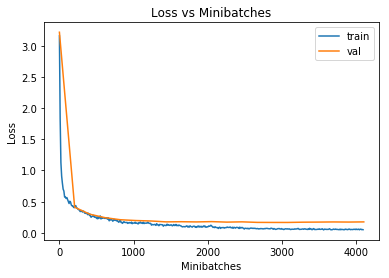

In [6]:
train, val = train_loss, valid_loss
X, Y = [ range(0,10*len(train),10), range(0,205*len(val),205) ], [ train, val ]
title, xlabel, ylabel = 'Loss vs Minibatches', 'Minibatches', 'Loss'
labels = ['train', 'val' ]
plot( X, Y, title, xlabel, ylabel, labels )